<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Experiments/Generator_to_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


For this experiment, we'll use a dataset from AI Crowd competition (live now) https://www.aicrowd.com/challenges/ai-blitz-8/problems/f1-team-classification

This is just for experiment purposes learning how to use `tf.data.Dataset.from_generators()` and this dataset was a suitable one to experiment with. 

# Creating a Dataset object from ImageDataGenerator 

Since I am new to tensorflow and the `tf.data` api I wasn't sure how to construct complex pipelines. It was easy using `ImageDataGenerator` (high-level api) especially with directory and dataframe to load in images. 

I came over this handy method `tf.data.Dataset.from_generator()` which help us createa a dataset object from the generator object itself. How cool? 

Try to wrap the `Dataset` class around this data generators.

We will be looking into `.flow_from_dataframe()` method. 

### Things we'll be doing
- Use transfer learning fine tuning to train our model
- Use mixed_precision 
- Use prefetch


In [1]:
# Checking the GPU 
!nvidia-smi

Thu May 20 20:35:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Getting some helper functions from Daniels' TensorFlow Course 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-20 20:35:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-20 20:35:11 (59.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Importing the needed functions for our use 
from helper_functions import plot_loss_curves , compare_historys

In [ ]:
# Using AI Crowd APi to download our data 

!pip install aicrowd-cli 

API_KEY = '#########'

!aicrowd login --api-key $API_KEY

In [ ]:
# Downloading the dataset 
!aicrowd dataset download --challenge f1-team-classification -j 3

!rm -rf data
!mkdir data

!unzip train.zip  -d data/train
!unzip val.zip -d data/val
!unzip test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

In [6]:
# Let's create a variable for our data paths 

train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'

# Our ImageID and label dataframes 
import pandas as pd 
import numpy as np 

df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/val.csv')

In [7]:
# Looking into our train dataframe 
df_train.head()

,ImageID,label
0,0,redbull
1,1,mercedes
2,2,redbull
3,3,redbull
4,4,redbull


## Becoming one with the data 

Alright now we've got our data and it's time to visualize it and see how they look. 

In [8]:
# Are the labels are well balanced? 
df_train['label'].value_counts()

redbull     20043
mercedes    19957
Name: label, dtype: int64

In [9]:
# How many images are there in the training directory? 
df_train['ImageID'].shape

(40000,)

In [10]:
# Defining some parameters
import tensorflow as tf 
BATCH_SIZE  = 64 
IMG_SIZE = (224 , 224)

In [11]:
# Creating our ImageDataGenerators for train and valid 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)


In [12]:
# How does our filenames looks like? 
import os 
print(os.listdir(train_dir)[:10])

['33821.jpg', '30578.jpg', '27097.jpg', '25608.jpg', '5723.jpg', '18465.jpg', '15993.jpg', '16175.jpg', '5418.jpg', '19479.jpg']


In [13]:
# Adding the jpg extension to our ImageID in our train and valid dataframe 

def append_ext(fn):
  return f'{fn}.jpg'

# Now applying our function 
df_train['ImageID'] = df_train['ImageID'].apply(append_ext)
df_val['ImageID'] = df_val['ImageID'].apply(append_ext)

In [14]:
# Looking into our ImageID column 
df_train['ImageID'][:5]

0    0.jpg
1    1.jpg
2    2.jpg
3    3.jpg
4    4.jpg
Name: ImageID, dtype: object

In [15]:
# Now it's time to import our data into the generator 

train_data_all = train_datagen.flow_from_dataframe(dataframe= df_train , 
                                               directory = train_dir , 
                                               x_col = 'ImageID' , 
                                               y_col = 'label' , 
                                               target_size = IMG_SIZE , 
                                               class_mode = 'binary' , 
                                               batch_size = 32 , 
                                               shuffle = True)

val_data_all = valid_datagen.flow_from_dataframe(dataframe = df_val , 
                                           directory = val_dir , 
                                           x_col = 'ImageID' , 
                                           y_col = 'label' , 
                                           target_size = IMG_SIZE , 
                                           class_mode = 'binary', 
                                           batch_size = 32 , 
                                           shuffle = True)


# Without any transformations (batch_size , imgsize etc..)
train_data_none = train_datagen.flow_from_dataframe(dataframe= df_train , 
                                               directory = train_dir , 
                                               x_col = 'ImageID' , 
                                               y_col = 'label' , 
                                               batch_size = 32 ,
                                               class_mode = 'binary' )

val_data_none = valid_datagen.flow_from_dataframe(dataframe = df_val , 
                                           directory = val_dir , 
                                           x_col = 'ImageID' , 
                                           y_col = 'label' , 
                                           batch_size = 32,
                                          class_mode = 'binary')


Found 40000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [16]:
# Checking the image , label shape and dtype (with transforms)
images, labels = next(train_data_all)

# Checking their shapes and dtypes
images.shape  , labels.shape , images.dtype , labels.dtype

((32, 224, 224, 3), (32,), dtype('float32'), dtype('float32'))

In [17]:
# Checking the image , label shapes an dtypes (without any transforms)
images_none , labels_none = next(train_data_none)

# Checking their shapes and dtypes 
images_none.shape , labels_none.shape , images_none.dtype , labels_none.dtype

((32, 256, 256, 3), (32,), dtype('float32'), dtype('float32'))

In [18]:
# Getting the class indices 
train_data_all.class_indices

{'mercedes': 0, 'redbull': 1}

### Creating a dataset using `tf.data.Dataset.from_generators()`

Now we're going to convert the generator into Dataset object using the `tf.data.Dataset.from_generator()`

Things to be noted: 
- In the place of `lambda` use your datagenerator object. 
- The **output_shapes** is really important because our dataset object will returns the exact shape we mention inside the `output_shapes`. 

This was the reason we examined our data types and shape above as soon as we built our generator. 

#### Creating a dataset with the transforms here  (just for experimentation)

In [19]:
train_dataset_all = tf.data.Dataset.from_generator(
    lambda: train_data_all , 
    output_types = (tf.float32 , tf.float32) , 
    output_shapes = ([32 , 224 , 224 , 3] , [32 , ])
)

valid_dataset_all = tf.data.Dataset.from_generator(
    lambda: val_data_all , 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([32 , 224 , 224 , 3] , [32 , ])
)

train_dataset_all , valid_dataset_all

(<FlatMapDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32)>,
 <FlatMapDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32)>)

#### Creating a dataset without any transforms (just for experimentations)

In [20]:
train_dataset_none = tf.data.Dataset.from_generator(
    lambda: train_data_none , 
    output_types = (tf.float32 , tf.float32) , 
    output_shapes = ([32 , 256 , 256 , 3] , [32 , ])
)

valid_dataset_none = tf.data.Dataset.from_generator(
    lambda: val_data_all , 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([32 , 256 , 256 , 3] , [32 , ])
)

train_dataset_none , valid_dataset_none

(<FlatMapDataset shapes: ((32, 256, 256, 3), (32,)), types: (tf.float32, tf.float32)>,
 <FlatMapDataset shapes: ((32, 256, 256, 3), (32,)), types: (tf.float32, tf.float32)>)

### **Note**

Since we're derived our from dataset object from a generator we won't be able to use `len()` function to know the number of samples in our dataset. 

We can use cardinality to get the number of samples in our dataset. It's because in our case after the conversion the length is unknown and infinite. 

`tf.data.experimental.cardinality` --> returns cardinality of the **dataset**

This will return -2 for now. 
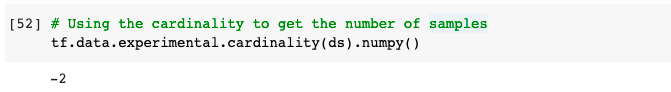



It should return **40000** (for train) because that was the number of samples (images) in our train directory. 
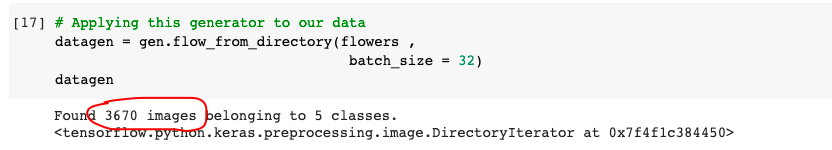

But don't worry we can even fix this by using a similar function, since our length is unknown and it's the common case when you convert from generator to a dataset object. 

We can explicitly enter our number of samples and even better we can use the `len()` function now on our dataset using, 

`tf.data.experimental.assert_cardinality()` --> Asserts the cardinality of the dataset. Now will apply this to our dataset.


In [21]:
# Using assert_cardinality to add the number of samples (input)
train_dataset_all = train_dataset_all.apply(tf.data.experimental.assert_cardinality(40000))
valid_dataset_all = valid_dataset_all.apply(tf.data.experimental.assert_cardinality(4000))

# Same for our without transformations dataset 
train_dataset_none = train_dataset_none.apply(tf.data.experimental.assert_cardinality(40000))
valid_dataset_none = valid_dataset_none.apply(tf.data.experimental.assert_cardinality(4000))


In [22]:
train_dataset_all , valid_dataset_all

(<_AssertCardinalityDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32)>,
 <_AssertCardinalityDataset shapes: ((32, 224, 224, 3), (32,)), types: (tf.float32, tf.float32)>)

In [23]:
# Now checkin the len 
len(train_dataset_all) , len(valid_dataset_all)

(40000, 4000)

In [33]:
# Setting up mixed precision 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = 'mixed_float16') 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [34]:
mixed_precision.global_policy() # should output "mixed_float16"


<Policy "mixed_float16">

In [35]:
# How many classes are there? 
train_data_all.class_indices

{'mercedes': 0, 'redbull': 1}

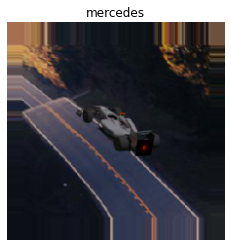

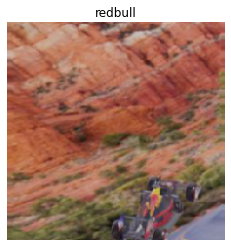

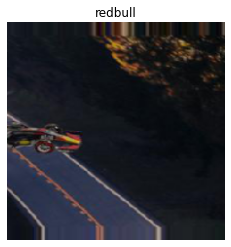

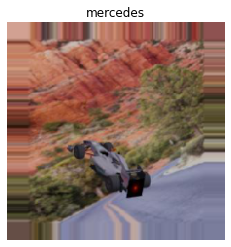

In [ ]:
# Visualizing our images 
import matplotlib.pyplot as plt

x , y  = train_data.next()
for i in range(0, 4):
  image = x[i]
  label = y[i]
  plt.axis(False)
  # print(label) --> for checking whether it's plotting right ones
  if label == 1.0:
    label = 'redbull'
  else:
    label = 'mercedes'
  plt.title(label)
  plt.imshow(image)
  plt.show()

In [37]:
# Getting our class names in a list
class_names = list(train_data_all.class_indices.keys())
len(class_names)

2

## Modelling 

In [57]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(1)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("sigmoid", dtype=tf.float32, name="softmax_float32")(x) 
model_1 = tf.keras.Model(inputs, outputs)



In [58]:
# Checking whether our layers are using mixed precision 
for layer in model_1.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_5 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [40]:
# Tensorflow addons for f1-score 
!pip install tensorflow_addons
import tensorflow_addons as tfa

f1_score = tfa.metrics.F1Score(average='macro' , num_classes= 1)


In [59]:
# Compile the model 
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy' , f1_score])

Let's train the model again

> **Note**: Before using `len(train_data)` in the `steps_per_epoch` we should divide it by our **batch_size**. 

In [60]:
# To get the actual steps for epochs for our train data
len(train_dataset_all) // 64

625

In [61]:
# Training a feature extraction model 
history_feature_model_1 = model_1.fit(train_dataset_all , 
                                      steps_per_epoch = len(train_dataset_all) // 32,
                                      epochs = 3 , 
                                      validation_data = valid_dataset_all, 
                                      validation_steps = int(0.15 * (len(valid_dataset_all))) ) 

Epoch 1/3
1250/1250 [==============================] - 152s 118ms/step - loss: 0.6947 - accuracy: 0.4989 - f1_score: 0.6667 - val_loss: 0.6931 - val_accuracy: 0.5055 - val_f1_score: 0.6618
Epoch 2/3
1250/1250 [==============================] - 146s 116ms/step - loss: 0.6947 - accuracy: 0.5034 - f1_score: 0.6633 - val_loss: 0.6983 - val_accuracy: 0.5049 - val_f1_score: 0.6623
Epoch 3/3
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6948 - accuracy: 0.4920 - f1_score: 0.6639 - val_loss: 0.6957 - val_accuracy: 0.4948 - val_f1_score: 0.6621


In [62]:
# Gotta unfreeze all the layers 
base_model.trainable = True

# Refreeze all layers except last 5 
for layer in base_model.layers[:-3]:
  layer.trainable = False

# Compiling the model again making the change 
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001) , 
                metrics = ['accuracy' , f1_score])

In [63]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [64]:
# Re-fit to fine tune the model 
initial_epochs = 5
fine_tune_epochs = initial_epochs + 25
history_fine_model_1 = model_1.fit(train_dataset_all , 
                                   steps_per_epoch = len(train_dataset_all) // 32 , 
                                   epochs = fine_tune_epochs , 
                                   initial_epoch = history_feature_model_1.epoch[-1] , 
                                   validation_data = valid_dataset_all , 
                                   validation_steps = int(0.15 * (len(valid_dataset_all))) , 
                                   callbacks = [reduce_lr])

Epoch 3/30
1250/1250 [==============================] - 151s 118ms/step - loss: 0.6951 - accuracy: 0.5050 - f1_score: 0.6656 - val_loss: 0.6951 - val_accuracy: 0.4953 - val_f1_score: 0.6624
Epoch 4/30
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6944 - accuracy: 0.5048 - f1_score: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.5073 - val_f1_score: 0.6602
Epoch 5/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6947 - accuracy: 0.4983 - f1_score: 0.6681 - val_loss: 0.6939 - val_accuracy: 0.4971 - val_f1_score: 0.6641
Epoch 6/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6943 - accuracy: 0.5001 - f1_score: 0.6683 - val_loss: 0.6930 - val_accuracy: 0.5061 - val_f1_score: 0.6612
Epoch 7/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6941 - accuracy: 0.5010 - f1_score: 0.6701 - val_loss: 0.6933 - val_accuracy: 0.4938 - val_f1_score: 0.6611
Epoch 8/30
1250/1250 [============================


### Log (should be improved)

Epoch 3/30
1250/1250 [==============================] - 151s 118ms/step - loss: 0.6951 - accuracy: 0.5050 - f1_score: 0.6656 - val_loss: 0.6951 - val_accuracy: 0.4953 - val_f1_score: 0.6624
Epoch 4/30
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6944 - accuracy: 0.5048 - f1_score: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.5073 - val_f1_score: 0.6602
Epoch 5/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6947 - accuracy: 0.4983 - f1_score: 0.6681 - val_loss: 0.6939 - val_accuracy: 0.4971 - val_f1_score: 0.6641
Epoch 6/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6943 - accuracy: 0.5001 - f1_score: 0.6683 - val_loss: 0.6930 - val_accuracy: 0.5061 - val_f1_score: 0.6612
Epoch 7/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6941 - accuracy: 0.5010 - f1_score: 0.6701 - val_loss: 0.6933 - val_accuracy: 0.4938 - val_f1_score: 0.6611
Epoch 8/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6941 - accuracy: 0.4985 - f1_score: 0.6630 - val_loss: 0.6931 - val_accuracy: 0.5199 - val_f1_score: 0.6628

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 9/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6933 - accuracy: 0.4955 - f1_score: 0.6656 - val_loss: 0.6931 - val_accuracy: 0.5056 - val_f1_score: 0.6616
Epoch 10/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6932 - accuracy: 0.5005 - f1_score: 0.6648 - val_loss: 0.6932 - val_accuracy: 0.4961 - val_f1_score: 0.6632

Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 11/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5013 - f1_score: 0.6666 - val_loss: 0.6932 - val_accuracy: 0.4939 - val_f1_score: 0.6612
Epoch 12/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5037 - f1_score: 0.6677 - val_loss: 0.6930 - val_accuracy: 0.5054 - val_f1_score: 0.6619

Epoch 00012: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 13/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6932 - accuracy: 0.4973 - f1_score: 0.6691 - val_loss: 0.6930 - val_accuracy: 0.5052 - val_f1_score: 0.6620
Epoch 14/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6932 - accuracy: 0.4954 - f1_score: 0.6728 - val_loss: 0.6931 - val_accuracy: 0.5091 - val_f1_score: 0.6610

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
Epoch 15/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5219 - f1_score: 0.6698 - val_loss: 0.6931 - val_accuracy: 0.4970 - val_f1_score: 0.6626
Epoch 16/30
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6931 - accuracy: 0.5025 - f1_score: 0.6658 - val_loss: 0.6931 - val_accuracy: 0.5027 - val_f1_score: 0.6623

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 17/30
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6931 - accuracy: 0.5117 - f1_score: 0.6680 - val_loss: 0.6931 - val_accuracy: 0.4972 - val_f1_score: 0.6609
Epoch 18/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5091 - f1_score: 0.6684 - val_loss: 0.6931 - val_accuracy: 0.4991 - val_f1_score: 0.6626

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 19/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5043 - f1_score: 0.6677 - val_loss: 0.6931 - val_accuracy: 0.4999 - val_f1_score: 0.6629
Epoch 20/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5048 - f1_score: 0.6670 - val_loss: 0.6931 - val_accuracy: 0.4975 - val_f1_score: 0.6609

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 21/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5094 - f1_score: 0.6707 - val_loss: 0.6931 - val_accuracy: 0.4972 - val_f1_score: 0.6626
Epoch 22/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5023 - f1_score: 0.6662 - val_loss: 0.6931 - val_accuracy: 0.5002 - val_f1_score: 0.6630

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 23/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5080 - f1_score: 0.6700 - val_loss: 0.6931 - val_accuracy: 0.4959 - val_f1_score: 0.6616
Epoch 24/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5017 - f1_score: 0.6656 - val_loss: 0.6931 - val_accuracy: 0.4978 - val_f1_score: 0.6614

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 25/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5032 - f1_score: 0.6659 - val_loss: 0.6931 - val_accuracy: 0.4993 - val_f1_score: 0.6627
Epoch 26/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5052 - f1_score: 0.6682 - val_loss: 0.6931 - val_accuracy: 0.4979 - val_f1_score: 0.6613

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 27/30
1250/1250 [==============================] - 147s 117ms/step - loss: 0.6931 - accuracy: 0.5065 - f1_score: 0.6702 - val_loss: 0.6931 - val_accuracy: 0.4976 - val_f1_score: 0.6628
Epoch 28/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5035 - f1_score: 0.6687 - val_loss: 0.6931 - val_accuracy: 0.4983 - val_f1_score: 0.6608

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 29/30
1250/1250 [==============================] - 147s 118ms/step - loss: 0.6931 - accuracy: 0.5078 - f1_score: 0.6692 - val_loss: 0.6931 - val_accuracy: 0.4980 - val_f1_score: 0.6615
Epoch 30/30
1250/1250 [==============================] - 146s 117ms/step - loss: 0.6931 - accuracy: 0.5074 - f1_score: 0.6713 - val_loss: 0.6931 - val_accuracy: 0.5005 - val_f1_score: 0.6632

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-07.

In [ ]:
d